In [172]:
# import torch
import numpy as np
import pandas as pd
df1 = pd.read_excel("test_data.xlsx")
df2 =pd.read_excel("train_data.xlsx")
df1['BRD4-BD1'].dropna()
df2['BRD4-BD1'].dropna()
print(df2[['SMILES','BRD4-BD1']].shape)

(528, 2)


数据预处理：选择是数字的行

In [173]:
df3=df2[['SMILES','BRD4-BD1','Class','Unit']][df2['BRD4-BD1'].apply(lambda x : type(x)==float)][df2['Class'].apply(lambda x:x=="IC50")].dropna()
df4=df1[['SMILES','BRD4-BD1','Class','Unit']][df1['BRD4-BD1'].apply(lambda x : type(x)==float)][df2['Class'].apply(lambda x:x=="IC50")].dropna()
df3.loc[df3['Unit']=='nM',['BRD4-BD1']] /=1000  # 训练样本
df3.loc[df3['Unit']=='nM',['Unit']] ='uM'
df4.loc[df4['Unit']=='nM',['BRD4-BD1']] /=1000 # 测试样本
df4.loc[df4['Unit']=='nM',['Unit']] ='uM'
df4=df4.reset_index()
df3 =df3.reset_index()
#print(X_train_smiles.shape,df3.shape)
#print(X_test_smiles.shape,df4)
# df3.to_csv(r'./train_check.csv',index=False,sep=',')  #重新保存
# df4.to_csv(r'./test_check.csv',index=False,sep=',') #重新保存

train_df = pd.read_csv("train__BRD4-BD1.csv")
test_df =pd.read_csv("train__BRD4-BD2.csv")
X_train_smiles = np.array(list(train_df["SMILES"]))
# # writer.save()
# print(X_train_smiles[1])

<ipython-input-173-3eec6c189a47>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3=df2[['SMILES','BRD4-BD1','Class','Unit']][df2['BRD4-BD1'].apply(lambda x : type(x)==float)][df2['Class'].apply(lambda x:x=="IC50")].dropna()
<ipython-input-173-3eec6c189a47>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4=df1[['SMILES','BRD4-BD1','Class','Unit']][df1['BRD4-BD1'].apply(lambda x : type(x)==float)][df2['Class'].apply(lambda x:x=="IC50")].dropna()


对SMILES格式进行编码，构建语料库

In [174]:
"""为出现的字符构建字典"""
charset = set("".join(list(df3.SMILES))+"!E")
"""为字符构建索引"""
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in df3.SMILES]) + 5 # 最长的len(smile)
print (str(charset))
print(len(charset), embed)
char_to_int
for key,val in char_to_int.items():
    # print(f"'{key}'",":",val)
    print(key,end=' ')

{'#', 'F', ')', '=', '1', '[', 'r', 'E', 'M', 'S', 'l', '*', '4', '+', 'H', '!', '5', 'N', 'C', 'g', '(', '2', 'O', ']', 'B', '3', '@', '-'}
28 97
# F ) = 1 [ r E M S l * 4 + H ! 5 N C g ( 2 O ] B 3 @ - 

Onehot编码向量化

In [175]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        # 为所有数据生成形状为（embed，len(charset))的onehot编码,
        for i,smile in enumerate(smiles):
            #encode the start char 开始编码为！
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar 结束编码为 E
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [176]:
vocab_size=len(charset)
vocab_size
X_train_4_5,_ = vectorize(X_train_smiles)
X_4_5 = np.argmax(X_train_4_5,axis=2)
X_4_5 # 对最后一个维度取最大下标，即表示其对应字符 (batch_size,sequence_length)

array([[15, 17,  9, ...,  7,  7,  7],
       [15, 17,  9, ...,  7,  7,  7],
       [15,  5, 14, ...,  7,  7,  7],
       ...,
       [15, 18, 22, ...,  7,  7,  7],
       [15, 18, 22, ...,  7,  7,  7],
       [15, 18, 22, ...,  7,  7,  7]], dtype=int64)

多任务训练集

In [177]:
train_df = pd.read_csv("train_BD1BD2.csv")
test_df =pd.read_csv("test_BD1BD2.csv")
X_train_smiles = np.array(list(train_df["SMILES"]))
X_test_smiles =np.array(list(test_df["SMILES"]))
assay1,assay2 = "BRD4-BD1"  ,"BRD4-BD2"
Y_train = train_df[[assay1,assay2]].values
Y_test = test_df[[assay1,assay2]].values
Y_train = np.array(Y_train)
print(Y_test)
Y_test = np.array(Y_test)
# Y_train_BD1=np.array([])
# for item in Y_train:
#     Y_train_BD1=np.append(Y_train_BD1,item[0])
# Y_train_BD1.reshape(-1,1)

[[3.28600e+02 2.60300e-01]
 [2.71200e+02 6.60200e-01]
 [9.52000e+01 8.08400e-01]
 [1.69100e+02 2.96381e+01]]


In [178]:
import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, LayerNormalization, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.layers import Dense, Dropout
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.losses import MeanSquaredError
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Keras: %s"%keras.__version__)

Keras: 2.4.3


定义网络

In [179]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [180]:
from keras import optimizers
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)


相关判断系数

In [181]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [182]:
from keras import backend as K
X_train, _ = vectorize(X_train_smiles)
X_test, _ = vectorize(X_test_smiles)
X_train = K.cast_to_floatx(X_train)
Y_train = K.cast_to_floatx(Y_train)
np.argmax(X_train,axis=2).shape

(33, 96)

In [183]:
x = Input(shape=(embed-1,))
shared =Embedding(vocab_size, 100, input_length=embed-1)(x)
conv1d1 =keras.layers.Conv1D(512,10,activation='relu')(shared)
# layernorm = LayerNormalization()(conv1d1)
conv1d2 = keras.layers.Conv1D(256,5,activation='relu')(conv1d1)
conv1d3 = keras.layers.Conv1D(128,3,activation='relu')(conv1d2)
flatten =Flatten()(conv1d3)
sub1= Dense(1024,activation='relu')(flatten)
sub2 = Dense(1024,activation='relu')(flatten)
# sub3 = Dense(1024,activation='relu')(flatten)
full1 = Dense(32)(sub1)
full2 = Dense(32)(sub2)
# full3 = Dense(32)(sub3)
out1= Dense(1)(full1)
out2= Dense(1)(full2)
# out3= Dense(1)(full3)
model = Model(inputs=x, outputs=[out1,out2])
model.summary()
model.compile(optimizer=optimizer,
              loss= MeanSquaredError(),
            )

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 96, 100)      2800        input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 87, 512)      512512      embedding_17[0][0]               
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 83, 256)      655616      conv1d_51[0][0]                  
______________________________________________________________________________________

In [184]:
callbacks_list = [
    # EarlyStopping(monitor="val_loss",patience=10),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]
history =model.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=10,
                              epochs=100,
                              validation_data=(np.argmax(X_test, axis=2),Y_test),
                              callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 3187.8252 - dense_127_loss: 1594.1326 - dense_128_loss: 1593.6927
Epoch 00001: val_loss improved from inf to 53558.73438, saving model to weights.best.hdf5
4/4 [==============================] - 1s 284ms/step - loss: 3187.8252 - dense_127_loss: 1594.1326 - dense_128_loss: 1593.6927 - val_loss: 53558.7344 - val_dense_127_loss: 26801.4414 - val_dense_128_loss: 26757.2930
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 3119.8208 - dense_127_loss: 1559.7731 - dense_128_loss: 1560.0480
Epoch 00002: val_loss improved from 53558.73438 to 51627.02344, saving model to weights.best.hdf5
4/4 [==============================] - 1s 238ms/step - loss: 3119.8208 - dense_127_loss: 1559.7731 - dense_128_loss: 1560.0480 - val_loss: 51627.0234 - val_dense_127_loss: 25848.1602 - val_dense_128_loss: 25778.8633
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 3068.5330 - dense_127_loss: 1534.4326 - dense_1

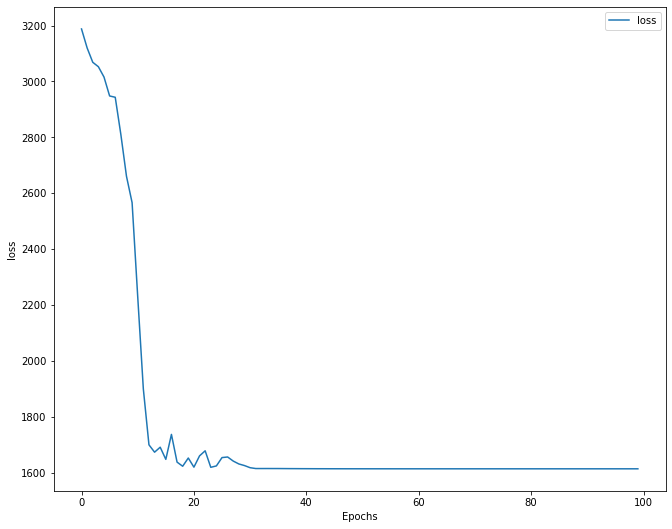

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
hist = history.history
plt.figure(figsize=(10, 8))
label ='loss'
plt.plot(hist[label], label = label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
# for label in ['val_coeff_determination','coeff_determination']:
#     plt.subplot(221)
#     plt.plot(hist[label], label = label)
#     plt.legend()
#     plt.xlabel("Epochs")
#     plt.ylabel("coeff_determination")

# for label in ['val_loss','loss']:
#     plt.subplot(222)
#     plt.plot(hist[label], label = label)
#     plt.legend()
#     plt.xlabel("Epochs")
#     plt.ylabel("loss")



# plt.subplot(223)
# plt.plot( hist['lr'],hist['val_coeff_determination']  )
# plt.legend()
# plt.xlabel("lr")
# plt.ylabel("val_coeff_determination")


# plt.subplot(224)
# plt.plot( hist['lr'],hist['val_loss']  )
# plt.legend()
# plt.xlabel("lr")
# plt.ylabel("val_loss")


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                wspace=0.35)

训练函数,采用五折交叉验证

观察结果

In [190]:
predict_test= model.predict(x=np.argmax(X_test, axis=2))
bd1,bd2 =Y_test.T
print(bd2)
print(abs(bd2-predict_test[1]))

#     print()
# print(Y_test[0:5])
# print(predict_test)
# print((abs(predict_test-Y_test)/Y_test).mean())

[ 0.2603  0.6602  0.8084 29.6381]
[[ 1.54921381  1.14931381  1.00111381 27.82858619]
 [ 5.4354984   5.0355984   4.8873984  23.9423016 ]
 [ 4.28313557  3.88323557  3.73503557 25.09466443]
 [ 2.96360771  2.56370771  2.41550771 26.41419229]]
